In [1]:
from image_classification_simulation.data.mnist_loader import MNISTLoader
from image_classification_simulation.data.office31_loader import Office31Loader
import typing
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from image_classification_simulation.data.data_loader import MyDataModule
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
import torchvision


In [2]:
args = {"batch_size": 32, "image_size": 28}
mnist_loader = MNISTLoader("../examples/data/", args)
mnist_loader.setup(stage="fit")
train_mnist = mnist_loader.train_dataloader()
test_mnist = mnist_loader.val_dataloader()

Number of workers set to: 1


In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.AdamW):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32 ,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(9216,256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,31)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [15]:
model = NaturalSceneClassification()

In [7]:
aaa = fit(1,3e-4,model,train_mnist,test_mnist)

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [8]:
args = {"batch_size": 8, "image_size": 100}
office31_loader = Office31Loader("../examples/data/domain_adaptation_images/amazon/images", args)
office31_loader.setup(stage="fit")
train_dl=office31_loader.train_dataloader()
val_dl=office31_loader.val_dataloader()

Number of workers set to: 1


Feature batch shape: torch.Size([8, 3, 100, 100])
Labels batch shape: torch.Size([8])


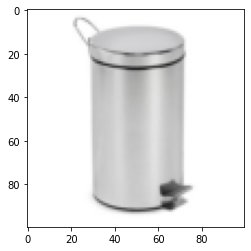

Label: 30


In [9]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [16]:
bbb = fit(2,3e-4,model,train_dl,val_dl)

Epoch [0], train_loss: 3.3806, val_loss: 3.0574, val_acc: 0.1458
Epoch [1], train_loss: 2.9871, val_loss: 2.6087, val_acc: 0.2500
